MoviePy - Writing audio in audio.wav


MoviePy - Done.
Audio extracted to audio.wav
INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz
INFO:spleeter:Validating archive checksum
INFO:spleeter:Extracting downloaded 2stems archive
INFO:spleeter:2stems model file(s) extracted
INFO:tensorflow:Using config: {'_model_dir': 'pretrained_models\\2stems', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
  per_process_gpu_memory_fraction: 0.7
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, 

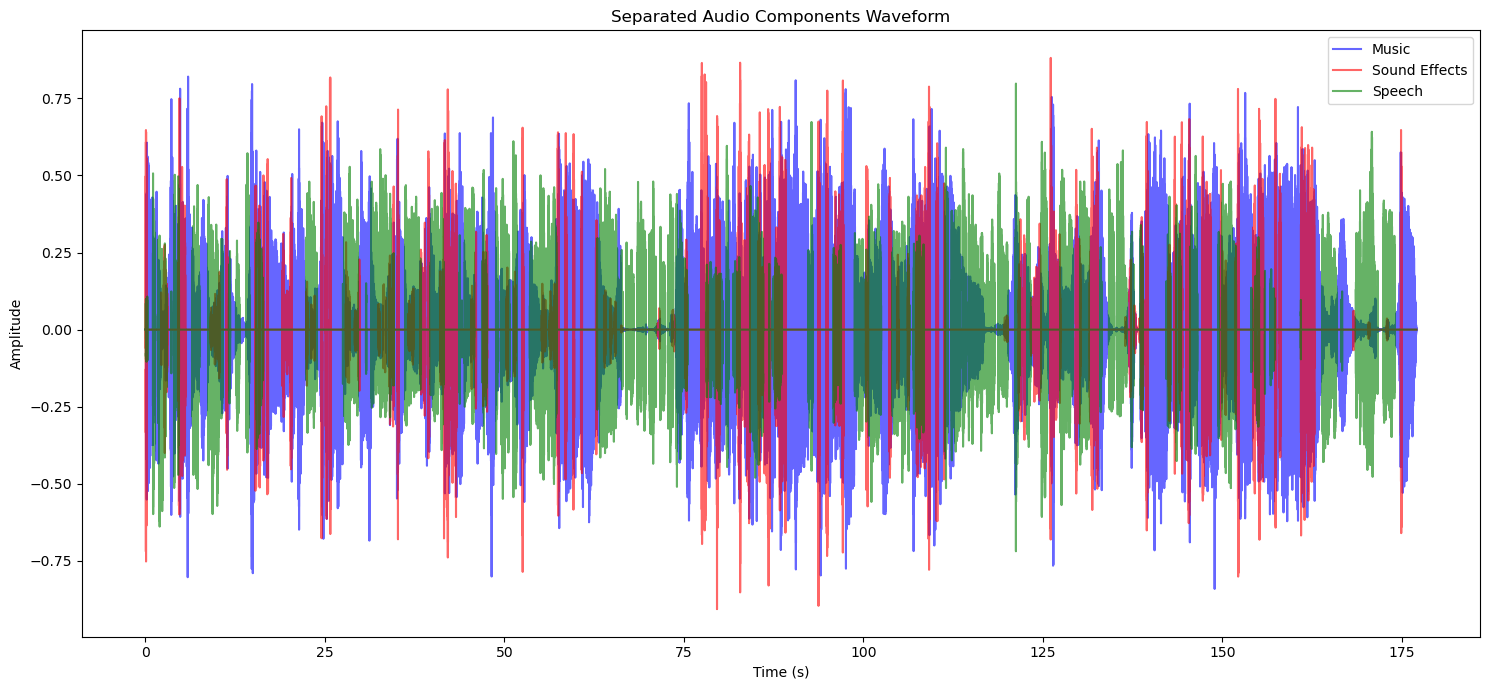

In [15]:
import os
import subprocess
import numpy as np
import librosa
import matplotlib.pyplot as plt
import moviepy.editor as mp

# Ensure you have the following libraries installed:
# !pip install numpy librosa matplotlib moviepy spleeter

# Step 1: Extract Audio from Video
def extract_audio_from_video(video_path, audio_output_path):
    clip = mp.VideoFileClip(video_path)
    clip.audio.write_audiofile(audio_output_path)
    print(f"Audio extracted to {audio_output_path}")

# Step 2: Separate Audio Components

# 2.1 Use Spleeter to separate vocals and accompaniment
def separate_audio(audio_input_path, output_directory):
    # Install spleeter if not already installed
    # !pip install spleeter

    from spleeter.separator import Separator

    # Initialize spleeter separator for 2 stems (vocals and accompaniment)
    separator = Separator('spleeter:2stems')
    separator.separate_to_file(audio_input_path, output_directory)
    print(f"Audio separated into vocals and accompaniment in {output_directory}")

# 2.2 Attempt to separate sound effects from accompaniment (approximate)
def estimate_sound_effects(accompaniment_audio_path, sr):
    y_accompaniment, _ = librosa.load(accompaniment_audio_path, sr=sr)

    # Use onset detection to estimate sound effects
    onset_env = librosa.onset.onset_strength(y=y_accompaniment, sr=sr)
    onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

    # Create a sound effects mask based on detected onsets
    sound_effects_mask = np.zeros_like(y_accompaniment)
    onset_samples = librosa.frames_to_samples(onsets)
    for onset in onset_samples:
        start = max(0, onset - int(0.05 * sr))  # 50 ms before onset
        end = min(len(sound_effects_mask), onset + int(0.1 * sr))  # 100 ms after onset
        sound_effects_mask[start:end] = 1

    # Music mask is the inverse of sound effects mask
    music_mask = 1 - sound_effects_mask

    # Apply masks
    y_sound_effects = y_accompaniment * sound_effects_mask
    y_music = y_accompaniment * music_mask

    return y_music, y_sound_effects

# 2.3 Perform Speech Activity Detection (SAD)
def detect_speech(vocals_audio_path, sr):
    y_vocals, _ = librosa.load(vocals_audio_path, sr=sr)

    # Simplified energy-based speech detection
    hop_length = 512
    frame_length = 1024
    energy = np.array([
        sum(abs(y_vocals[i:i+frame_length]**2))
        for i in range(0, len(y_vocals), hop_length)
    ])
    threshold = np.mean(energy) * 0.5  # Adjust the multiplier as needed
    speech_frames = energy > threshold

    # Expand frames back to samples
    speech_mask = np.repeat(speech_frames, hop_length)
    speech_mask = speech_mask[:len(y_vocals)]

    y_speech = y_vocals * speech_mask

    return y_speech

# Step 3: Generate and Plot Waveforms
def plot_waveforms(y_music, y_sound_effects, y_speech, sr):
    # Create time axis
    time_music = np.linspace(0, len(y_music) / sr, num=len(y_music))
    time_sound_effects = np.linspace(0, len(y_sound_effects) / sr, num=len(y_sound_effects))
    time_speech = np.linspace(0, len(y_speech) / sr, num=len(y_speech))

    plt.figure(figsize=(15, 7))

    # Plot Music waveform
    plt.plot(time_music, y_music, color='blue', alpha=0.6, label='Music')

    # Plot Sound Effects waveform
    plt.plot(time_sound_effects, y_sound_effects, color='red', alpha=0.6, label='Sound Effects')

    # Plot Speech waveform
    plt.plot(time_speech, y_speech, color='green', alpha=0.6, label='Speech')

    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Separated Audio Components Waveform')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function to run all steps
def main():
    video_file = 'trailer.mp4'  # Replace with your video file path
    audio_file = 'audio.wav'
    output_dir = 'output'

    # Step 1: Extract audio from video
    extract_audio_from_video(video_file, audio_file)

    # Step 2: Separate audio components
    separate_audio(audio_file, output_dir)

    # Paths to separated audio files
    base_name = os.path.splitext(os.path.basename(audio_file))[0]
    vocals_file = os.path.join(output_dir, base_name, 'vocals.wav')
    accompaniment_file = os.path.join(output_dir, base_name, 'accompaniment.wav')

    # Load sample rate
    y_full, sr = librosa.load(audio_file, sr=None)

    # 2.2 Estimate music and sound effects
    y_music, y_sound_effects = estimate_sound_effects(accompaniment_file, sr)

    # 2.3 Detect speech
    y_speech = detect_speech(vocals_file, sr)

    # Step 3: Plot waveforms
    plot_waveforms(y_music, y_sound_effects, y_speech, sr)

if __name__ == '__main__':
    main()


In [13]:
pip install spleeter

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.0 MB 10.1 MB/s eta 0:00:01
   ----------------------- ---------------- 6.6/11.0 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 20.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/444.1 MB ? eta -:--:--
   - -------------------------------------- 12.6/444.1 MB 60.7 MB/s eta 0:00:08
   --- ------------------------------------ 34.1/444.1 MB 83.3 MB/s eta 0:00:05
   ----- ---------------------------------- 59.8/444.1 MB 95.2 MB/s eta 0:00:05
   ------- ------------------------------- 83.6/444.1 MB 100.7 MB/s eta 0:00:04
   -------- ------------------------------ 100.9/444.1 MB 97.6 MB/s eta 0:00:04
   ---------- ---------------------------- 115.1/444.1 MB 91.9 MB/s eta 0:00:04
   ----------- --------------------------- 135.0/444.1 MB 92.7 MB/s eta 0:00:04
   ------------- ------------------------- 156.5/444.1 MB 94.3 M

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 24.4.2 requires click>=8.0.0, but you have click 7.1.2 which is incompatible.
conda-index 0.5.0 requires click>=8, but you have click 7.1.2 which is incompatible.
flask 3.0.3 requires click>=8.1.3, but you have click 7.1.2 which is incompatible.
spyder 5.2.2 requires pyqt5<5.13, but you have pyqt5 5.15.10 which is incompatible.
spyder 5.2.2 requires pyqtwebengine<5.13, but you have pyqtwebengine 5.15.6 which is incompatible.
